In [2]:
import pandas as pd
from ctgan import CTGAN
import numpy as np

# Load data
df = pd.read_csv('Diabetes.csv')
TARGET = 'Diabetes_binary'

CATEGORICAL_COLUMNS = [
    'Diabetes_binary',
    'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke',
    'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
    'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost',
    'DiffWalk', 'Sex', 'Education', 'Income'
]

# Train CTGAN
ctgan = CTGAN(epochs=1000, verbose=True)
ctgan.fit(df, discrete_columns=CATEGORICAL_COLUMNS)

# Identify imbalance
counts = df[TARGET].value_counts()
maj, min_ = counts.idxmax(), counts.idxmin()
n_to_sample = counts[maj] - counts[min_]
print(f"Need to generate {n_to_sample} synthetic rows for class={min_}")

# Generate batches until enough minority samples are collected
collected = []
batch_size = 50_000
total_collected = 0

while total_collected < n_to_sample:
    batch = ctgan.sample(batch_size)
    batch_min = batch[batch[TARGET] == min_]
    if not batch_min.empty:
        collected.append(batch_min)
        total_collected += len(batch_min)
        print(f"Collected so far: {total_collected} / {n_to_sample}")

# Concatenate and keep exactly n_to_sample rows
synthetic_minority = pd.concat(collected, ignore_index=True).sample(n=n_to_sample, random_state=42)
synthetic_minority['source'] = 'synthetic'

# Save synthetic samples
synthetic_minority.to_csv('CTGAN_synthetic_minority_only.csv', index=False)

# Combine with original data to form a balanced dataset
df['source'] = 'real'
df_balanced = pd.concat([df, synthetic_minority], ignore_index=True)
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
df_balanced.to_csv('CTGAN_balanced_diabetes.csv', index=False)

print("Balanced dataset saved to 'CTGAN_balanced_diabetes_final.csv'")

Gen. (-0.10) | Discrim. (-0.40): 100%|██████████| 1000/1000 [3:56:08<00:00, 14.17s/it]   


Need to generate 182988 synthetic rows for class=1.0
Collected so far: 7342 / 182988
Collected so far: 14749 / 182988
Collected so far: 21927 / 182988
Collected so far: 29324 / 182988
Collected so far: 36760 / 182988
Collected so far: 43960 / 182988
Collected so far: 51323 / 182988
Collected so far: 58749 / 182988
Collected so far: 66096 / 182988
Collected so far: 73450 / 182988
Collected so far: 80879 / 182988
Collected so far: 88210 / 182988
Collected so far: 95624 / 182988
Collected so far: 103025 / 182988
Collected so far: 110428 / 182988
Collected so far: 117780 / 182988
Collected so far: 125026 / 182988
Collected so far: 132420 / 182988
Collected so far: 139818 / 182988
Collected so far: 147049 / 182988
Collected so far: 154314 / 182988
Collected so far: 161571 / 182988
Collected so far: 169101 / 182988
Collected so far: 176528 / 182988
Collected so far: 183792 / 182988
Balanced dataset saved to 'CTGAN_balanced_diabetes_final.csv'


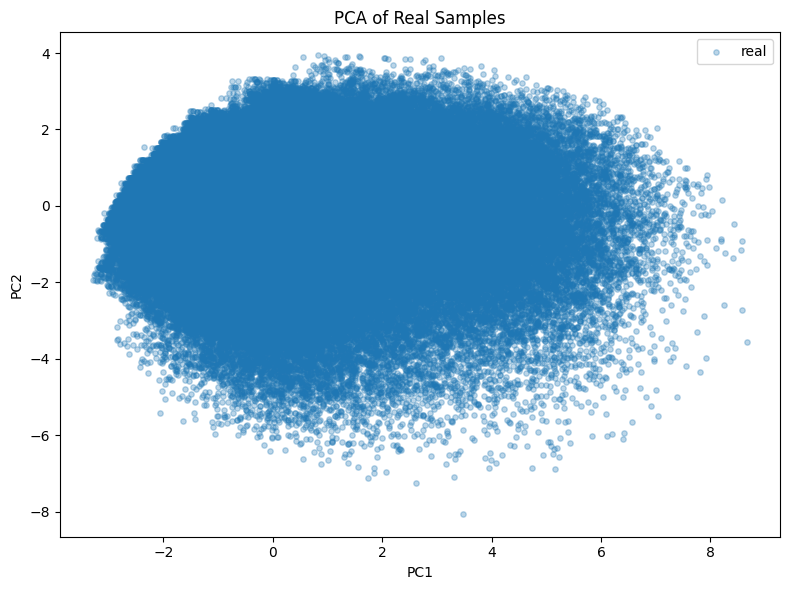

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming df is your original real dataset and TARGET is defined
real = df.copy()
real['source'] = 'real'

# Select features excluding the target and source columns
feats = [c for c in real.columns if c not in (TARGET, 'source')]

# Standardize the features
X = StandardScaler().fit_transform(real[feats])

# Apply PCA to reduce to 2 components
pcs = PCA(n_components=2).fit_transform(X)

# Add the principal components to the real dataframe
real['PC1'], real['PC2'] = pcs[:, 0], pcs[:, 1]

# Plot the PCA results for real data only
plt.figure(figsize=(8, 6))
plt.scatter(real['PC1'], real['PC2'], alpha=0.3, s=15, label='real')
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Real Samples')
plt.tight_layout()
plt.show()

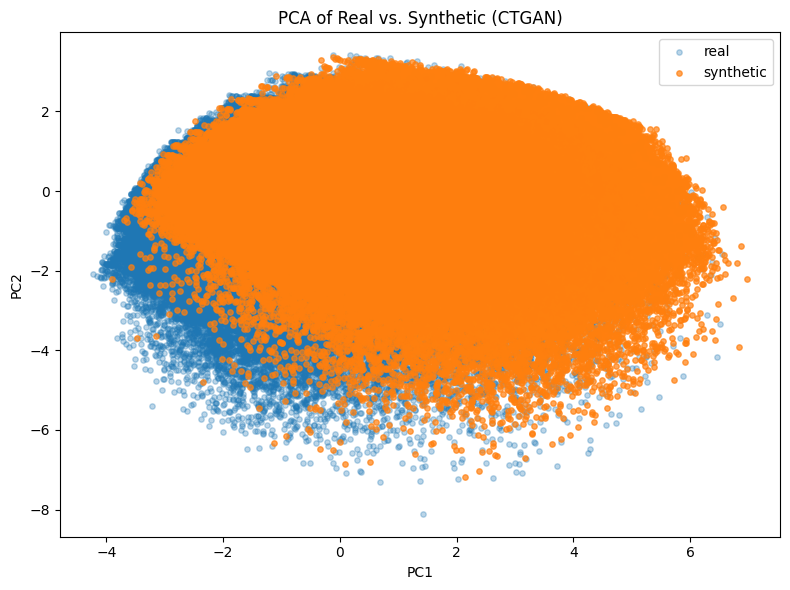

In [ ]:
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    
    real = df.copy();    real['source'] = 'real'
    synthetic_minority['source'] = 'synthetic'
    combined = pd.concat([real, synthetic_minority], ignore_index=True)
    
    feats = [c for c in combined.columns if c not in (TARGET, 'source')]
    X = StandardScaler().fit_transform(combined[feats])
    
    pcs = PCA(n_components=2).fit_transform(X)
    combined['PC1'], combined['PC2'] = pcs[:,0], pcs[:,1]
    
    plt.figure(figsize=(8,6))
    for src, a in [('real',0.3),('synthetic',0.7)]:
        sub = combined[combined['source']==src]
        plt.scatter(sub['PC1'], sub['PC2'], alpha=a, s=15, label=src)
    plt.legend(); plt.xlabel('PC1'); plt.ylabel('PC2')
    plt.title('PCA of Real vs. Synthetic (CTGAN)'); plt.tight_layout()
    plt.show()


Binary features identified: ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']

JSD Evaluation of CTGAN:

Feature              JSD Score 
------------------------------
HighBP               0.0040    
HighChol             0.0664    
CholCheck            0.0046    
BMI                  0.1445    
Smoker               0.0246    
Stroke               0.1337    
HeartDiseaseorAttack 0.0892    
PhysActivity         0.0541    
Fruits               0.0102    
Veggies              0.0079    
HvyAlcoholConsump    0.0058    
AnyHealthcare        0.0028    
NoDocbcCost          0.0677    
GenHlth              0.0910    
MentHlth             0.2000    
PhysHlth             0.2447    
DiffWalk             0.0213    
Sex                  0.0508    
Age                  0.3715    
Education            0.1302    
Income               0.1206    

Quality Assessment:


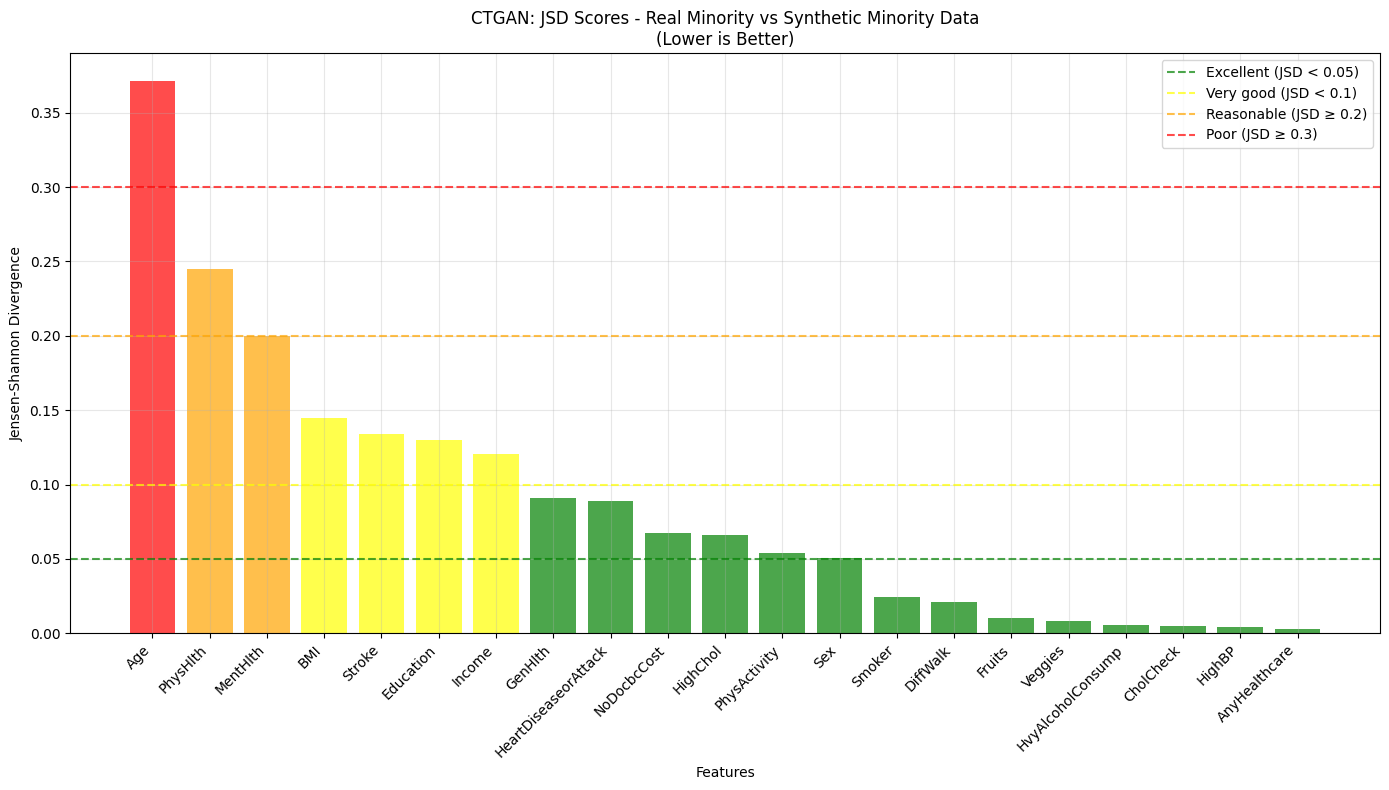


JSD INTERPRETATION GUIDE
0.0 - 0.05: Excellent match (distributions are almost identical)
0.05 - 0.1: Very good match (minor differences)
0.1 - 0.2: Reasonable match (some noticeable differences)
0.2 - 0.3: Noticeable differences (distributions differ)
> 0.3: Significant differences (poor match)


In [6]:
import numpy as np
import pandas as pd
from scipy.spatial import distance
import matplotlib.pyplot as plt

# 1. CONFIGURATION
TARGET = 'Diabetes_binary'
MINORITY_CLASS = 1.0
DATA_PATH = 'CTGAN_balanced_diabetes.csv'
THRESHOLD = 0.5

# 2. LOAD DATA
df = pd.read_csv(DATA_PATH)

# 3. THRESHOLD SYNTHETIC DATA (MODIFIED FOR CTGAN)
def threshold_synthetic_data(df, threshold=0.5):
    """Convert continuous synthetic outputs to binary for categorical features"""
    binary_features = []
    for col in df.select_dtypes(include=[np.number]).columns:
        if col == TARGET: 
            continue
        # Look at REAL data to determine if feature is binary
        unique_vals = df[df['source'] == 'real'][col].unique()
        if set(unique_vals).issubset({0, 1}) and len(unique_vals) <= 2:
            binary_features.append(col)
    
    print(f"Binary features identified: {binary_features}")
    
    # Apply thresholding to synthetic data only
    synth_mask = df['source'] == 'synthetic'
    for feature in binary_features:
        df.loc[synth_mask, feature] = (df.loc[synth_mask, feature] > threshold).astype(float)
    
    return df

# APPLY THRESHOLDING
df = threshold_synthetic_data(df)

# 4. JSD CALCULATION FUNCTION
def compute_jsd(p, q, bins=50):
    """Calculate Jensen-Shannon Divergence between two distributions"""
    range_min = min(np.min(p), np.min(q))
    range_max = max(np.max(p), np.max(q))
    p_hist, _ = np.histogram(p, bins=bins, range=(range_min, range_max), density=True)
    q_hist, _ = np.histogram(q, bins=bins, range=(range_min, range_max), density=True)
    p_hist = np.maximum(p_hist, 1e-10)
    q_hist = np.maximum(q_hist, 1e-10)
    p_hist /= p_hist.sum()
    q_hist /= q_hist.sum()
    return distance.jensenshannon(p_hist, q_hist)

# 5. CALCULATE JSD FOR EACH FEATURE (MODIFIED FOR CTGAN)
print("\nJSD Evaluation of CTGAN:\n")
print("{:<20} {:<10}".format('Feature', 'JSD Score'))
print("-" * 30)

numeric_cols = df.select_dtypes(include=[np.number]).columns.drop(TARGET)
jsd_results = []

for col in numeric_cols:
    # REAL minority data (source == 'real' for CTGAN)
    real_data = df[(df['source'] == 'real') & (df[TARGET] == MINORITY_CLASS)][col].values
    
    # SYNTHETIC data (source == 'synthetic' for CTGAN)
    synth_data = df[df['source'] == 'synthetic'][col].values
    
    if len(real_data) == 0 or len(synth_data) == 0:
        print(f"{col}: Skipped (no data)")
        continue
        
    jsd = compute_jsd(real_data, synth_data)
    jsd_results.append((col, jsd))
    print("{:<20} {:<10.4f}".format(col, jsd))

# 6. QUALITY ASSESSMENT
jsd_scores = [score for _, score in jsd_results]
total_features = len(jsd_scores)
excellent_match = sum(1 for score in jsd_scores if score < 0.05)
good_match = sum(1 for score in jsd_scores if score < 0.1)

print(f"\nQuality Assessment:")
print(f"Excellent matches (JSD < 0.05): {excellent_match}/{total_features} ({excellent_match/total_features:.1%})")
print(f"Good matches (JSD < 0.1): {good_match}/{total_features} ({good_match/total_features:.1%})")
print(f"Poor matches (JSD >= 0.1): {total_features - good_match}/{total_features} ({(total_features - good_match)/total_features:.1%})")

# 7. VISUALIZATION
plt.figure(figsize=(14, 8))
features, scores = zip(*sorted(jsd_results, key=lambda x: x[1], reverse=True))

colors = [
    'red' if score >= 0.3 else 
    'orange' if score >= 0.2 else 
    'yellow' if score >= 0.1 else 
    'green' 
    for score in scores
]

bars = plt.bar(range(len(features)), scores, color=colors, alpha=0.7)

plt.axhline(y=0.05, color='green', linestyle='--', alpha=0.7, label='Excellent (JSD < 0.05)')
plt.axhline(y=0.1, color='yellow', linestyle='--', alpha=0.7, label='Very good (JSD < 0.1)')
plt.axhline(y=0.2, color='orange', linestyle='--', alpha=0.7, label='Reasonable (JSD ≥ 0.2)')
plt.axhline(y=0.3, color='red', linestyle='--', alpha=0.7, label='Poor (JSD ≥ 0.3)')
plt.xlabel('Features')
plt.ylabel('Jensen-Shannon Divergence')
plt.title('CTGAN: JSD Scores - Real Minority vs Synthetic Minority Data\n(Lower is Better)')
plt.xticks(range(len(features)), features, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 8. INTERPRETATION GUIDE
print("\n" + "="*60)
print("JSD INTERPRETATION GUIDE")
print("="*60)
print("0.0 - 0.05: Excellent match (distributions are almost identical)")
print("0.05 - 0.1: Very good match (minor differences)")
print("0.1 - 0.2: Reasonable match (some noticeable differences)")
print("0.2 - 0.3: Noticeable differences (distributions differ)")
print("> 0.3: Significant differences (poor match)")